In [1]:
# Install necessary packages
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

# Define a dictionary with file IDs and destination paths
file_info = {
    "traindemographics.xlsx": "1Z5-82djNrPtWqB4FxKjFQhW-PsyegYBv",
    "trainperf.csv": "17-t7XhFnPO22YJOQraXOmLC8FuJKVBup",
    "trainprevloans.csv": "1F9YcGdJz9aF9O2JngplBBaLphJMvzpOQ"
}

# Download each file and save it to the corresponding destination path
for filename, file_id in file_info.items():
    gdd.download_file_from_google_drive(file_id=file_id, dest_path="./" + filename, unzip=False)

In [2]:
import pandas as pd
import numpy as np

In [3]:
perf=pd.read_csv("trainperf.csv",index_col="customerid")
prev=pd.read_csv("trainprevloans.csv",index_col="customerid")
demo=pd.read_excel("traindemographics.xlsx",header=1,index_col="customerid")

In [4]:
#This data set contains the target variable along with features directly related to the loan application
perf.columns

Index(['systemloanid', 'loannumber', 'approveddate', 'creationdate',
       'loanamount', 'totaldue', 'termdays', 'referredby', 'good_bad_flag'],
      dtype='object')

In [5]:
#This data set contains information about customer's previous loan applications
prev.columns

Index(['systemloanid', 'loannumber', 'approveddate', 'creationdate',
       'loanamount', 'totaldue', 'termdays', 'closeddate', 'referredby',
       'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [6]:
#This data set contains demographiic information about customers
demo.columns

Index(['birthdate', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'bank_branch_clients', 'employment_status_clients',
       'level_of_education_clients'],
      dtype='object')

In [7]:
#Demographics and performance can be merged right away since they are both aligned directly on customerid. 
#However there are over 1000 loan application customers that we do not have demographic data for
df=perf.merge(demo,left_index=True,right_index=True)
print(f"THE MERGED DATASETS ARE {len(df)} ROWS, WHILE PERF IS: {len(perf)}")

THE MERGED DATASETS ARE 3277 ROWS, WHILE PERF IS: 4368


In [8]:
#In order to merge in the previous loan data we need to aggregate it and tranform features into more useful state

#Convert date time features into datetime object
prev['firstduedate']=prev['firstduedate'].apply(pd.to_datetime)
prev['firstrepaiddate']=prev['firstrepaiddate'].apply(pd.to_datetime)
prev['closeddate']=prev['closeddate'].apply(pd.to_datetime)
#Positive value indicates early repayment
prev['avg_hours_repaid_before_due']=prev[["firstduedate","firstrepaiddate"]]
.apply(lambda x: (x["firstduedate"]-x["firstrepaiddate"]).total_seconds()//3600,axis=1)
prev['avg_hours_close_to_firstduedate']=prev[["firstduedate","closeddate"]]
.apply(lambda x: (x["closeddate"]-x["firstduedate"]).total_seconds()//3600,axis=1)
#Rename loan amount so it isn't conflated with the loan amount in the application
prev['avg_loan_amount']=prev['loanamount']

In [9]:
#Merge in the prev loan information that is going to be averaged
df=df.merge(prev.reset_index()
            [["customerid","avg_loan_amount",'avg_hours_repaid_before_due','avg_hours_close_to_firstduedate']]
            .groupby(by="customerid").mean(),left_index=True,right_index=True)

In [10]:
#it may also be advantageous to indicate the count of late paid loans the customer has had
prev['loans_late']=prev.reset_index()[['avg_hours_repaid_before_due','customerid']]
.groupby(by="customerid").apply(lambda x: np.sum(x<0))
#Merge in the prev loan information that is "maxxed"
df=df.merge(prev.reset_index()[['customerid','loans_late']]
            .groupby(by="customerid").max(),left_index=True,right_index=True)

In [11]:
df.dtypes

systemloanid                         int64
loannumber                           int64
approveddate                        object
creationdate                        object
loanamount                         float64
totaldue                           float64
termdays                             int64
referredby                          object
good_bad_flag                       object
birthdate                           object
bank_account_type                   object
longitude_gps                      float64
latitude_gps                       float64
bank_name_clients                   object
bank_branch_clients                 object
employment_status_clients           object
level_of_education_clients          object
avg_loan_amount                    float64
avg_hours_repaid_before_due        float64
avg_hours_close_to_firstduedate    float64
loans_late                           int64
dtype: object

In [12]:
#Still have some null values in our combined data set
df.isna().sum()

systemloanid                          0
loannumber                            0
approveddate                          0
creationdate                          0
loanamount                            0
totaldue                              0
termdays                              0
referredby                         2822
good_bad_flag                         0
birthdate                             0
bank_account_type                     0
longitude_gps                         0
latitude_gps                          0
bank_name_clients                     0
bank_branch_clients                3242
employment_status_clients           493
level_of_education_clients         2832
avg_loan_amount                       0
avg_hours_repaid_before_due           0
avg_hours_close_to_firstduedate       0
loans_late                            0
dtype: int64

In [13]:
#Convert target variable to binary
df['good_bad_flag']=df['good_bad_flag'].apply(lambda x: 1 if x=="Good" else 0)

In [14]:
missing_coords = df.groupby('good_bad_flag').apply(lambda x: ((x['referredby'].isna())).sum())
missing_coords

good_bad_flag
0     604
1    2218
dtype: int64

In [15]:
def categorize_referral(customerid,df):

     try:
         loans=df.loc[customerid]
         num_loans=len(loans)

         if num_loans==0:
             return 0
         #if the referrer has mostly "bad" loans consider it a bad referral
         elif (loans['loans_late'].max()/num_loans)>.50:
             return 1
         else:
             return 2
     except KeyError:
         return 3

<Axes: xlabel='referredby', ylabel='Count'>

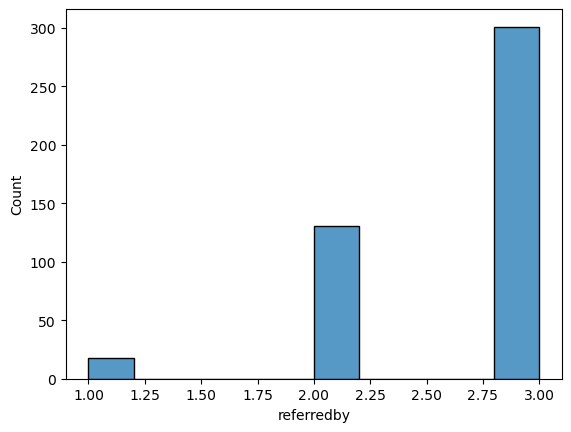

In [16]:
import seaborn as sns
sns.histplot(df['referredby'].dropna().apply(lambda x: categorize_referral(x,prev)))
#Most of the referred by data we DO have we dont have customer data for the person who made the referral

In [17]:
#Convert referreby feature to simple binary indicating whether a referral was made or not
df['referredby']=df['referredby'].apply(lambda x: 1 if isinstance(x,str)==True else 0)

In [18]:
features_with_missing_values =['employment_status_clients','bank_branch_clients','level_of_education_clients']
for item in features_with_missing_values:
  df[item]=df[item].fillna("no_disclosure")

In [19]:
df.isna().sum()

systemloanid                       0
loannumber                         0
approveddate                       0
creationdate                       0
loanamount                         0
totaldue                           0
termdays                           0
referredby                         0
good_bad_flag                      0
birthdate                          0
bank_account_type                  0
longitude_gps                      0
latitude_gps                       0
bank_name_clients                  0
bank_branch_clients                0
employment_status_clients          0
level_of_education_clients         0
avg_loan_amount                    0
avg_hours_repaid_before_due        0
avg_hours_close_to_firstduedate    0
loans_late                         0
dtype: int64

In [20]:
df.head()

systemloanid  loannumber  \
customerid                                                   
8a1088a0484472eb01484669e3ce4e0b     301999397           2   
8a1a1e7e4f707f8b014f797718316cad     301997672           5   
8a1a32fc49b632520149c3b8fdf85139     301976551           8   
8a1eb5ba49a682300149c3c068b806c7     301975382           9   
8a26bd845089f1d7015090b1d6f53bad     301997559          10   

                                                approveddate  \
customerid                                                     
8a1088a0484472eb01484669e3ce4e0b  2017-07-27 19:44:08.000000   
8a1a1e7e4f707f8b014f797718316cad  2017-07-26 20:01:54.000000   
8a1a32fc49b632520149c3b8fdf85139  2017-07-13 19:22:15.000000   
8a1eb5ba49a682300149c3c068b806c7  2017-07-13 00:34:03.000000   
8a26bd845089f1d7015090b1d6f53bad  2017-07-26 18:49:30.000000   

                                                creationdate  loanamount  \
customerid                                                                 
8a1088a0484472eb01484669e3ce4e0b  2017-07-27 18:44:00.000000     10000.0   
8a1a1e7e4f707f8b014f797718316cad  2017-07-26 19:01:46.000000     30000.0   
8a1a32fc49b632520149c3b8fdf85139  2017-07-13 18:22:05.000000     20000.0   
8a1eb5ba49a682300149c3c068b806c7  2017-07-12 23:33:54.000000     30000.0   
8a26bd845089f1d7015090b1d6f53bad  2017-07-26 17:49:23.000000     20000.0   

                                  totaldue  termdays  referredby  \
customerid                                                         
8a1088a0484472eb01484669e3ce4e0b   11500.0        15           0   
8a1a1e7e4f707f8b014f797718316cad   39000.0        60           0   
8a1a32fc49b632520149c3b8fdf85139   24500.0        30           0   
8a1eb5ba49a682300149c3c068b806c7   39000.0        60           0   
8a26bd845089f1d7015090b1d6f53bad   24500.0        30           0   

                                  good_bad_flag                   birthdate  \
customerid                                                                    
8a1088a0484472eb01484669e3ce4e0b              0  1989-11-09 00:00:00.000000   
8a1a1e7e4f707f8b014f797718316cad              1  1979-10-18 00:00:00.000000   
8a1a32fc49b632520149c3b8fdf85139              1  1979-01-29 00:00:00.000000   
8a1eb5ba49a682300149c3c068b806c7              1  1978-11-25 00:00:00.000000   
8a26bd845089f1d7015090b1d6f53bad              1  1987-04-03 00:00:00.000000   

                                  ... longitude_gps  latitude_gps  \
customerid                        ...                               
8a1088a0484472eb01484669e3ce4e0b  ...      3.351667      6.657019   
8a1a1e7e4f707f8b014f797718316cad  ...      3.395230      6.592192   
8a1a32fc49b632520149c3b8fdf85139  ...      3.306388      6.651843   
8a1eb5ba49a682300149c3c068b806c7  ...      3.426698      6.423048   
8a26bd845089f1d7015090b1d6f53bad  ...      3.486608      6.622080   

                                   bank_name_clients  \
customerid                                             
8a1088a0484472eb01484669e3ce4e0b             GT Bank   
8a1a1e7e4f707f8b014f797718316cad  Standard Chartered   
8a1a32fc49b632520149c3b8fdf85139             GT Bank   
8a1eb5ba49a682300149c3c068b806c7          First Bank   
8a26bd845089f1d7015090b1d6f53bad         Access Bank   

                                                                bank_branch_clients  \
customerid                                                                            
8a1088a0484472eb01484669e3ce4e0b                                          OJUELEGBA   
8a1a1e7e4f707f8b014f797718316cad                                      no_disclosure   
8a1a32fc49b632520149c3b8fdf85139                                      MUSHIN BRANCH   
8a1eb5ba49a682300149c3c068b806c7  17, SANUSI FAFUNWA STREET, VICTORIA ISLAND, LAGOS   
8a26bd845089f1d7015090b1d6f53bad                                      no_disclosure   

                                 employment_status_clients  \
customerid                           

In [21]:
df['age']=(pd.to_datetime(df['birthdate']).apply(lambda x: (pd.Timestamp.today()-x).days))
df=df.drop('birthdate',axis=1)

In [22]:
df=df.drop(['approveddate','creationdate','bank_branch_clients'],axis=1)

In [23]:
Target0=df.loc[df["good_bad_flag"]==0]
Target1=df.loc[df["good_bad_flag"]==1]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3272 entries, 8a1088a0484472eb01484669e3ce4e0b to 8a858fff5c79144c015c7bdbfc086ce1
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   systemloanid                     3272 non-null   int64  
 1   loannumber                       3272 non-null   int64  
 2   loanamount                       3272 non-null   float64
 3   totaldue                         3272 non-null   float64
 4   termdays                         3272 non-null   int64  
 5   referredby                       3272 non-null   int64  
 6   good_bad_flag                    3272 non-null   int64  
 7   bank_account_type                3272 non-null   object 
 8   longitude_gps                    3272 non-null   float64
 9   latitude_gps                     3272 non-null   float64
 10  bank_name_clients                3272 non-null   object 
 11  employment_status_clients   

In [25]:
df.columns

Index(['systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays',
       'referredby', 'good_bad_flag', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'employment_status_clients',
       'level_of_education_clients', 'avg_loan_amount',
       'avg_hours_repaid_before_due', 'avg_hours_close_to_firstduedate',
       'loans_late', 'age'],
      dtype='object')

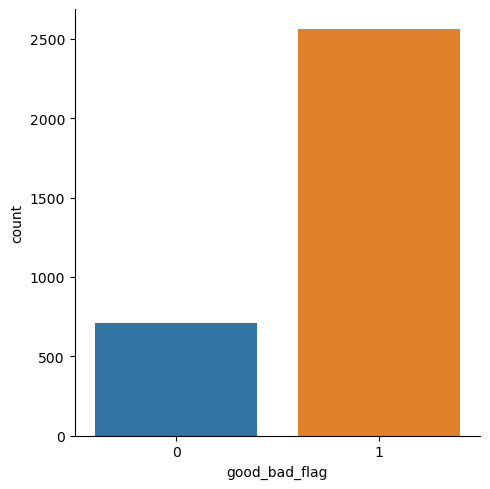

In [26]:
# Explore Target distribution
import seaborn as sns
sns.catplot(x="good_bad_flag", kind="count", data=df)

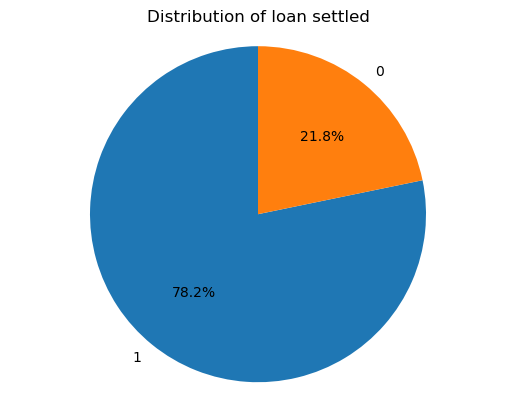

In [27]:

import matplotlib.pyplot as plt

loan_account_counts = df['good_bad_flag'].value_counts()
explode = [0.05] * len(loan_account_counts)

# Get the labels and sizes for the pie chart
labels = loan_account_counts.index
sizes = loan_account_counts.values

# Create the pie chart using matplotlib
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Aspect ratio to make the pie circular
plt.axis('equal')

# Add a title
plt.title('Distribution of loan settled')

# Show the pie chart
plt.show()

Our dataset iis poorly balanced. We need to keep this in mind when evaluating our model

array([[<Axes: title={'center': 'systemloanid'}>,
        <Axes: title={'center': 'loannumber'}>,
        <Axes: title={'center': 'loanamount'}>,
        <Axes: title={'center': 'totaldue'}>],
       [<Axes: title={'center': 'termdays'}>,
        <Axes: title={'center': 'referredby'}>,
        <Axes: title={'center': 'good_bad_flag'}>,
        <Axes: title={'center': 'longitude_gps'}>],
       [<Axes: title={'center': 'latitude_gps'}>,
        <Axes: title={'center': 'avg_loan_amount'}>,
        <Axes: title={'center': 'avg_hours_repaid_before_due'}>,
        <Axes: title={'center': 'avg_hours_close_to_firstduedate'}>],
       [<Axes: title={'center': 'loans_late'}>,
        <Axes: title={'center': 'age'}>, <Axes: >, <Axes: >]],
      dtype=object)

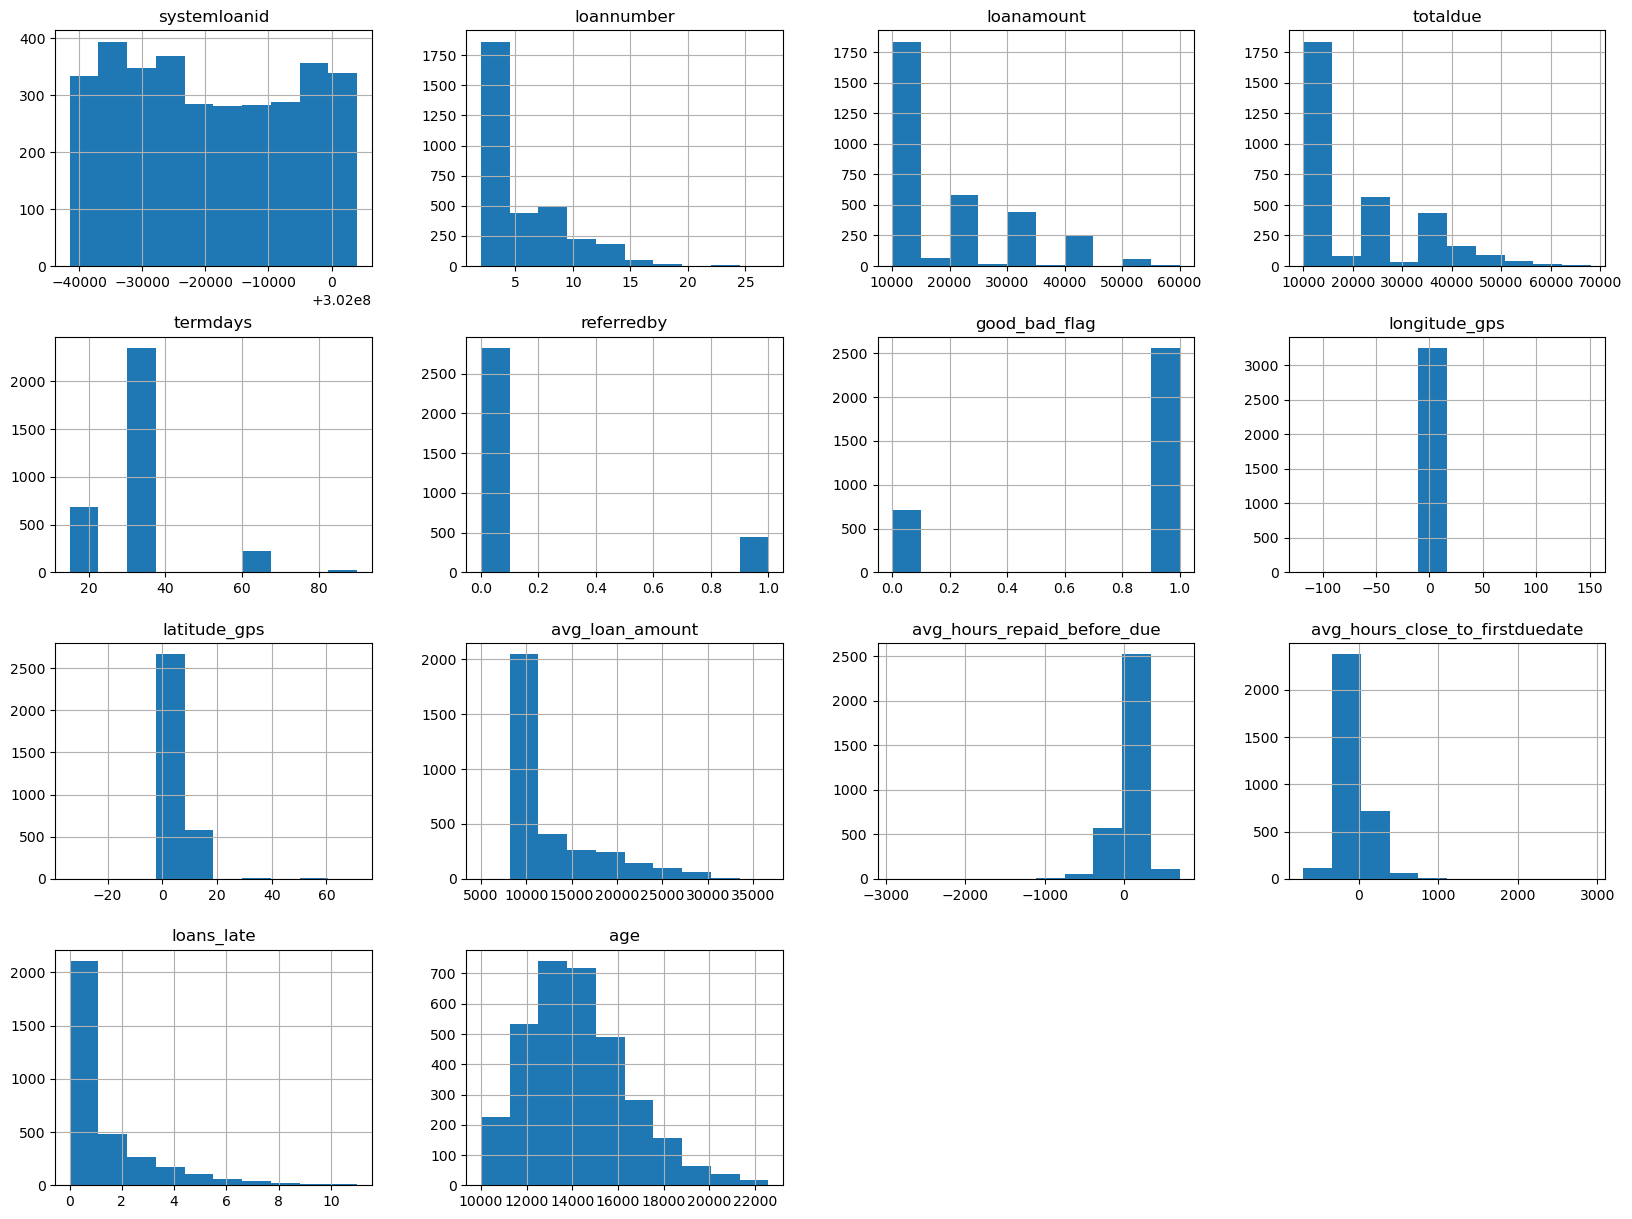

In [28]:
df.hist(figsize=(20,15))

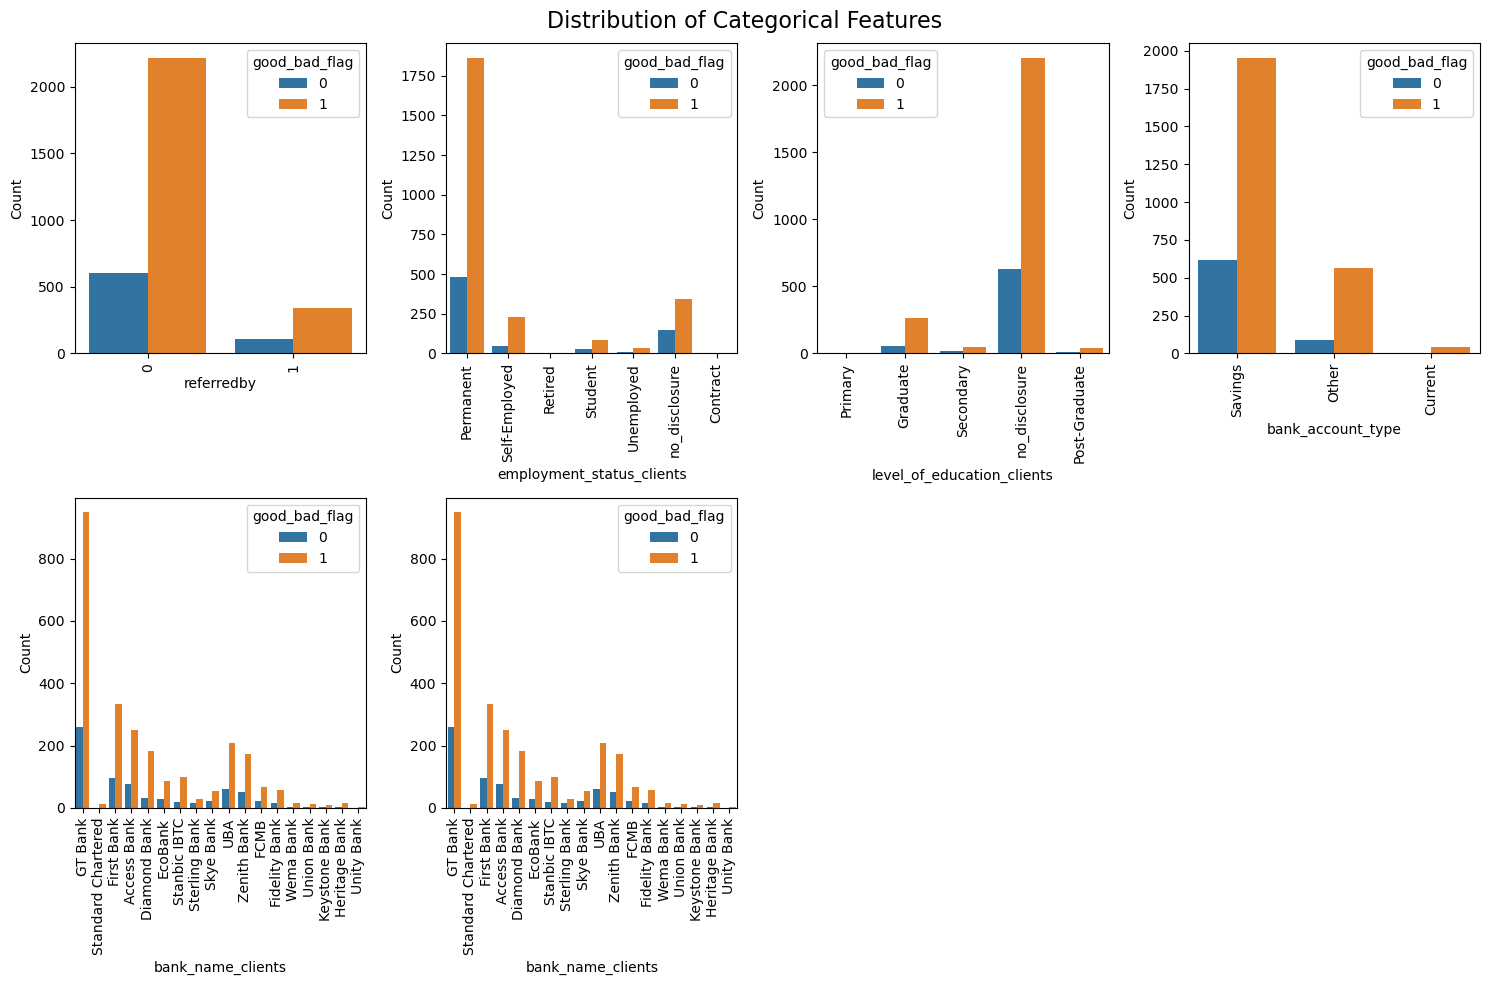

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df_subset1 = df[['good_bad_flag', 'employment_status_clients','referredby',
    'level_of_education_clients',
        'bank_account_type','bank_name_clients']]

categorical_features = ['referredby',
                        'employment_status_clients',
                       'level_of_education_clients',
                        'bank_account_type',
                        'bank_name_clients','bank_name_clients'
                    ]

# Determine the number of rows and columns for subplots
num_plots_per_row = 4
num_rows = (len(categorical_features) + num_plots_per_row - 1) // num_plots_per_row

# Create subplots for each categorical feature
fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5*num_rows))

for i, feature in enumerate(categorical_features):
    # Calculate the row and column indices for the current subplot
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row

    # Create a count plot for the current categorical feature
    sns.countplot(x=feature, data=df_subset1, hue='good_bad_flag', ax=axs[row_idx, col_idx])
    axs[row_idx, col_idx].set_xlabel(feature)
    axs[row_idx, col_idx].set_ylabel('Count')
    axs[row_idx, col_idx].tick_params(axis='x', rotation=90)
# Set the main title at the top
plt.suptitle('Distribution of Categorical Features', fontsize=16)

# Hide any empty subplots
for i in range(len(categorical_features), num_plots_per_row*num_rows):
    row_idx = i // num_plots_per_row
    col_idx = i % num_plots_per_row
    axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()


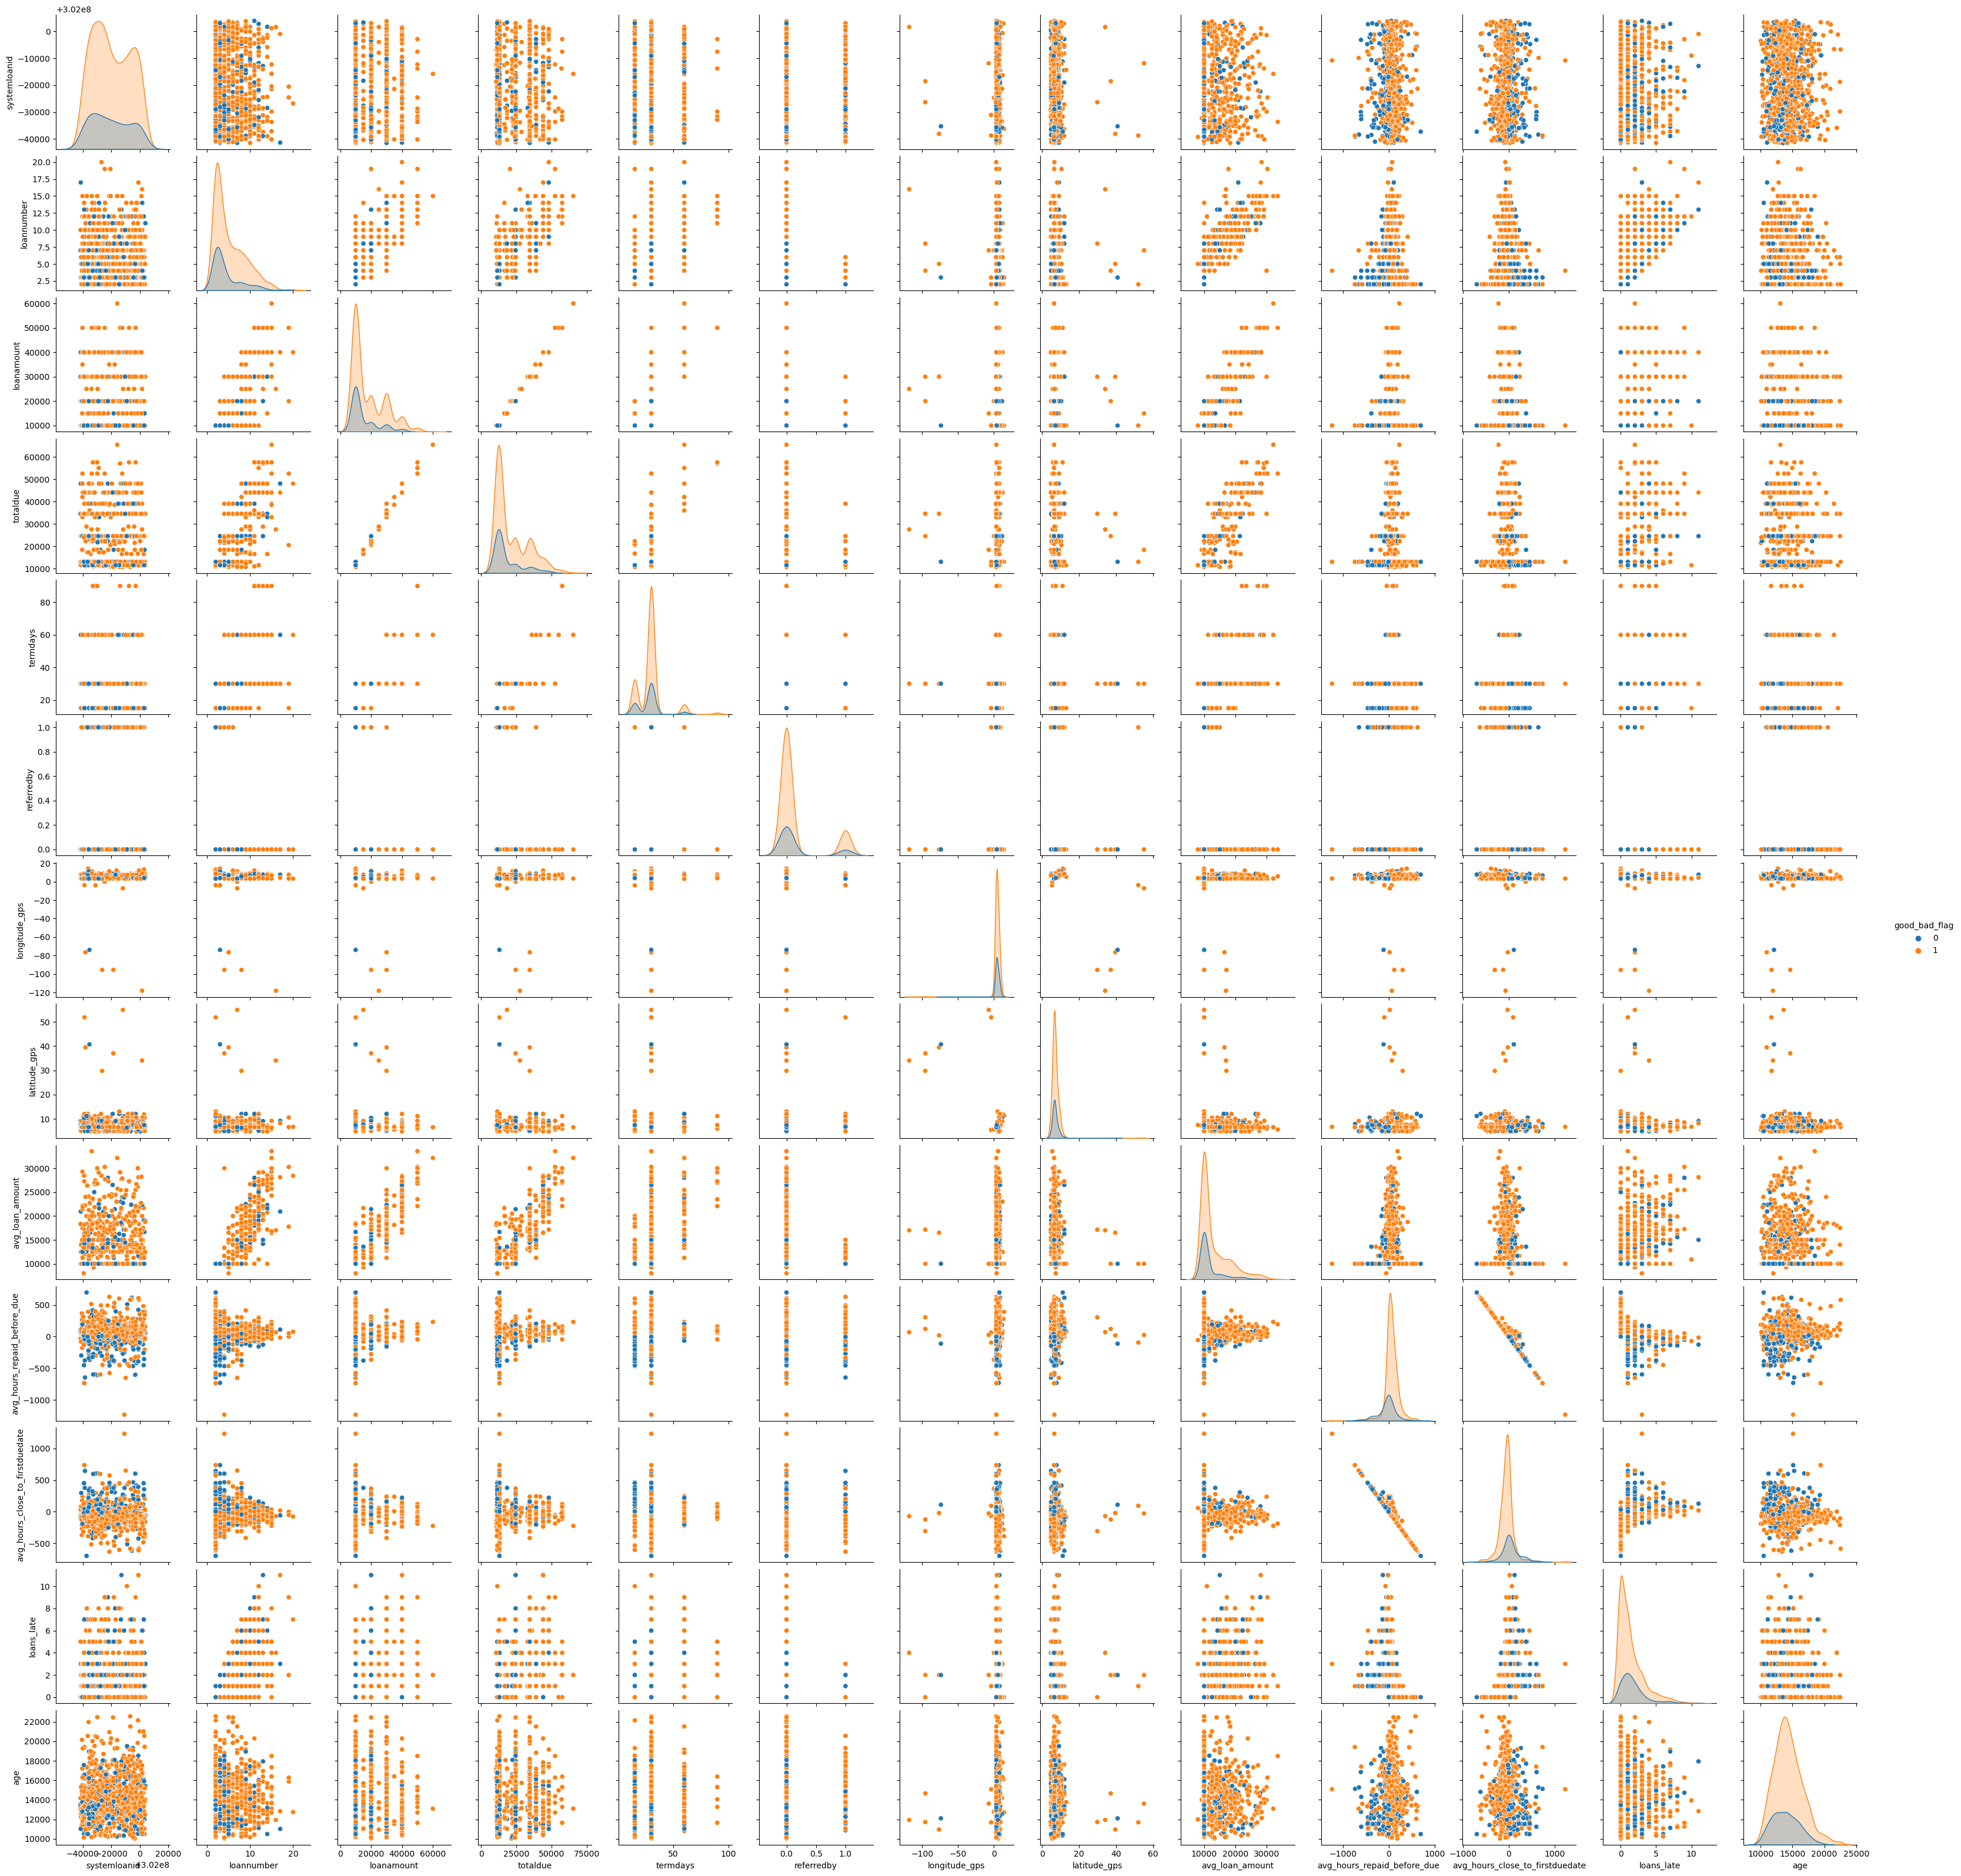

In [30]:
# show distribution of numerical features
df_subset = df.drop(columns= ['bank_name_clients','employment_status_clients',
                       'level_of_education_clients',
                        'bank_account_type',
                        ])
sns.pairplot(df_subset.sample(1000, random_state=10086), hue="good_bad_flag")

DEFINE X and Y

In [31]:
TARGET = "good_bad_flag"
columns_predictors = [col for col in df.columns if col not in [TARGET]]
columns_categorical = ['bank_name_clients',
        'employment_status_clients',
                       'level_of_education_clients',
                        'bank_account_type']
columns_numerical = [col for col in columns_predictors if col not in columns_categorical]
print(f"TARGET: {TARGET}")
print(f"columns_predictors: {columns_predictors}")
print(f"columns_categorical: {columns_categorical}")
print(f"columns_numerical: {columns_numerical}")

X = df[columns_predictors]
y = df[TARGET]
display(X)
display(y)

TARGET: good_bad_flag
columns_predictors: ['systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays', 'referredby', 'bank_account_type', 'longitude_gps', 'latitude_gps', 'bank_name_clients', 'employment_status_clients', 'level_of_education_clients', 'avg_loan_amount', 'avg_hours_repaid_before_due', 'avg_hours_close_to_firstduedate', 'loans_late', 'age']
columns_categorical: ['bank_name_clients', 'employment_status_clients', 'level_of_education_clients', 'bank_account_type']
columns_numerical: ['systemloanid', 'loannumber', 'loanamount', 'totaldue', 'termdays', 'referredby', 'longitude_gps', 'latitude_gps', 'avg_loan_amount', 'avg_hours_repaid_before_due', 'avg_hours_close_to_firstduedate', 'loans_late', 'age']


systemloanid  loannumber  loanamount  \
customerid                                                               
8a1088a0484472eb01484669e3ce4e0b     301999397           2     10000.0   
8a1a1e7e4f707f8b014f797718316cad     301997672           5     30000.0   
8a1a32fc49b632520149c3b8fdf85139     301976551           8     20000.0   
8a1eb5ba49a682300149c3c068b806c7     301975382           9     30000.0   
8a26bd845089f1d7015090b1d6f53bad     301997559          10     20000.0   
...                                        ...         ...         ...   
8a858fff5a28d297015a338c644f5053     301966641           5     20000.0   
8a858fff5a28d297015a33bc2e845305     301961209           7     30000.0   
8a858fff5a36fe68015a37f8550a02a2     301989105           7     30000.0   
8a858fff5a36fe68015a3b8dcb8a3843     301992274           7     30000.0   
8a858fff5c79144c015c7bdbfc086ce1     301967027           2     10000.0   

                                  totaldue  termdays  referredby  \
customerid                                                         
8a1088a0484472eb01484669e3ce4e0b   11500.0        15           0   
8a1a1e7e4f707f8b014f797718316cad   39000.0        60           0   
8a1a32fc49b632520149c3b8fdf85139   24500.0        30           0   
8a1eb5ba49a682300149c3c068b806c7   39000.0        60           0   
8a26bd845089f1d7015090b1d6f53bad   24500.0        30           0   
...                                    ...       ...         ...   
8a858fff5a28d297015a338c644f5053   24500.0        30           0   
8a858fff5a28d297015a33bc2e845305   39000.0        60           0   
8a858fff5a36fe68015a37f8550a02a2   34500.0        30           0   
8a858fff5a36fe68015a3b8dcb8a3843   34500.0        30           0   
8a858fff5c79144c015c7bdbfc086ce1   13000.0        30           0   

                                 bank_account_type  longitude_gps  \
customerid                                                          
8a1088a0484472eb01484669e3ce4e0b           Savings       3.351667   
8a1a1e7e4f707f8b014f797718316cad             Other       3.395230   
8a1a32fc49b632520149c3b8fdf85139           Savings       3.306388   
8a1eb5ba49a682300149c3c068b806c7           Savings       3.426698   
8a26bd845089f1d7015090b1d6f53bad             Other       3.486608   
...                                            ...            ...   
8a858fff5a28d297015a338c644f5053           Savings       7.498690   
8a858fff5a28d297015a33bc2e845305           Savings       6.985570   
8a858fff5a36fe68015a37f8550a02a2           Savings       3.491421   
8a858fff5a36fe68015a3b8dcb8a3843           Savings       3.291219   
8a858fff5c79144c015c7bdbfc086ce1           Savings       7.224332   

                                  latitude_gps   bank_name_clients  \
customerid                                                           
8a1088a0484472eb01484669e3ce4e0b      6.657019             GT Bank   
8a1a1e7e4f707f8b014f797718316cad      6.592192  Standard Chartered   
8a1a32fc49b632520149c3b8fdf85139      6.651843             GT Bank   
8a1eb5ba49a682300149c3c068b806c7      6.423048          First Bank   
8a26bd845089f1d7015090b1d6f53bad      6.622080         Access Bank   
...                                        ...                 ...   
8a858fff5a28d297015a338c644f5053      9.055047                 UBA   
8a858fff5a28d297015a33bc2e845305      4.806448          Union Bank   
8a858fff5a36fe68015a37f8550a02a2      6.439399          First Bank   
8a858fff5a36fe68015a3b8dcb8a3843      6.559089             GT Bank   
8a858fff5c79144c015c7bdbfc086ce1      8.884774                FCMB   

                                 employment_status_clients  \
customerid                                                   
8a1088a0484472eb01484669e3ce4e0b                 Permanent   
8a1a1e7e4f707f8b014f797718316cad                 Permanent   
8a1a32fc49b632520149c3b8fdf85139                 Permanent   
8a1eb5ba49a682300149c3c068b806c7                 Permanent   
8a26b

customerid
8a1088a0484472eb01484669e3ce4e0b    0
8a1a1e7e4f707f8b014f797718316cad    1
8a1a32fc49b632520149c3b8fdf85139    1
8a1eb5ba49a682300149c3c068b806c7    1
8a26bd845089f1d7015090b1d6f53bad    1
                                   ..
8a858fff5a28d297015a338c644f5053    1
8a858fff5a28d297015a33bc2e845305    1
8a858fff5a36fe68015a37f8550a02a2    1
8a858fff5a36fe68015a3b8dcb8a3843    1
8a858fff5c79144c015c7bdbfc086ce1    1
Name: good_bad_flag, Length: 3272, dtype: int64

In [32]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 42, stratify =y )

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (2454, 17)
X_test.shape: (818, 17)
y_train.shape: (2454,)
y_test.shape: (818,)


DATA PREPROCESSING WITH PIPELINE

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

pipeline_categorical = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
pipeline_numerical = Pipeline([('scaler', MinMaxScaler(feature_range=(0, 1)))])
pipeline_full = ColumnTransformer([('categorical', pipeline_categorical, columns_categorical),
                                   ('numerical', pipeline_numerical, columns_numerical)])

pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.fit_transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)

print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")



X_train_transformed.shape: (2454, 46)
X_test_transformed.shape: (818, 46)


In [35]:
#Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

pca=PCA(.95)
pipeline_categorical = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
pipeline_numerical = Pipeline([('scaler', MinMaxScaler(feature_range=(0, 1)))])
pipeline_full = ColumnTransformer([('categorical', pipeline_categorical, columns_categorical),
                                   ('numerical', pipeline_numerical, columns_numerical)])
pipe=Pipeline(steps=[("transformer",pipeline_full),('pca',pca)])
pipe.fit(X_train)
X_train_transformed_ = pipe.fit_transform(X_train)
X_test_transformed_ = pipe.transform(X_test)

print(f"X_train_transformed.shape: {X_train_transformed_.shape}")
print(f"X_test_transformed.shape: {X_test_transformed_.shape}")

X_train_transformed.shape: (2454, 22)
X_test_transformed.shape: (818, 22)


Logistic Regression, KNN, Decision Tree, Random Forest

In [36]:
!pip install -U scikit-learn imbalanced-learn

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

# Try PCA
logit_reg_pca = LogisticRegression(class_weight='balanced', random_state =42, max_iter =1000).fit(X_train_transformed_, y_train)
# KNN
knn_clf_pca = KNeighborsClassifier()
knn_clf_pca.fit(X_train_transformed_, y_train)

# RandomForest
rdf_clf_pca = RandomForestClassifier(n_estimators =100, max_depth = None,min_samples_split =2, random_state= 42)
rdf_clf_pca.fit(X_train_transformed_,y_train)

bbc_clf_pca = BalancedBaggingClassifier(n_estimators =100)
bbc_clf_pca.fit(X_train_transformed_,y_train)

brfc_clf_pca = BalancedRandomForestClassifier(n_estimators =100, max_depth = None,min_samples_split =2, random_state= 42)
brfc_clf_pca.fit(X_train_transformed_,y_train)
# Cross_validation
np.random.seed(42)
from sklearn.model_selection import cross_val_score
print("CROSS VALIDATION SCORES FOR MODELS WITH PCA")
def cross_validation(model):
  cv_scores = cross_val_score(model, X_train_transformed_, y_train, cv=5)
  print(model)
  print('cross_val_scores:',cv_scores)
  print('mean accuracy:',cv_scores.mean())
  print('standard deviation:', cv_scores.std())
  print("                                    ")
models = [logit_reg_pca, knn_clf_pca, rdf_clf_pca, bbc_clf_pca , brfc_clf_pca]
for model in models:
  cross_validation(model)

CROSS VALIDATION SCORES FOR MODELS WITH PCA
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
cross_val_scores: [0.61303462 0.59266802 0.58655804 0.598778   0.56734694]
mean accuracy: 0.5916771270626378
standard deviation: 0.015004732847925974
                                    
KNeighborsClassifier()
cross_val_scores: [0.75356415 0.75356415 0.75152749 0.74949084 0.76938776]
mean accuracy: 0.7555068789226486
standard deviation: 0.007102891789878147
                                    
RandomForestClassifier(random_state=42)
cross_val_scores: [0.75763747 0.77800407 0.80040733 0.78004073 0.78367347]
mean accuracy: 0.7799526164844758
standard deviation: 0.013667554844176621
                                    
BalancedBaggingClassifier(n_estimators=100)
cross_val_scores: [0.66395112 0.67413442 0.70264766 0.6904277  0.7122449 ]
mean accuracy: 0.688681158817906
standard deviation: 0.017756946435429754
                                    
BalancedRandomForestClassi

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
logit_reg = LogisticRegression(class_weight='balanced', random_state =42, max_iter =1000).fit(X_train_transformed, y_train)
# KNN
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, y_train)

#Decision Tree
dt_clf= DecisionTreeClassifier(random_state=42, max_depth=None)
dt_clf.fit(X_train_transformed, y_train)

# RandomForest
rdf_clf = RandomForestClassifier(n_estimators =100, max_depth = None,min_samples_split =2, random_state= 42)
rdf_clf.fit(X_train_transformed,y_train)

#Balanced Bagging Classifier
bbc_clf = BalancedBaggingClassifier(n_estimators =100)
bbc_clf.fit(X_train_transformed,y_train)

#Balanced Random Forest
brfc_clf = BalancedRandomForestClassifier(n_estimators =100, max_depth = None,min_samples_split =2, random_state= 42)
brfc_clf.fit(X_train_transformed,y_train)

# Cross_validation
np.random.seed(42)
from sklearn.model_selection import cross_val_score
print("CROSS VALIDATION SCORES FOR MODELS WITHOUT PCA")
def cross_validation(model):
  cv_scores = cross_val_score(model, X_train_transformed, y_train, cv=5)
  print(model)
  print('cross_val_scores:',cv_scores)
  print('mean accuracy:',cv_scores.mean())
  print('standard deviation:', cv_scores.std())
  print("                                    ")
models = [logit_reg, knn_clf,dt_clf, rdf_clf,bbc_clf,brfc_clf]
for model in models:
  cross_validation(model)


CROSS VALIDATION SCORES FOR MODELS WITHOUT PCA
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
cross_val_scores: [0.63543788 0.6089613  0.6191446  0.60488798 0.59591837]
mean accuracy: 0.6128700278482065
standard deviation: 0.013527958275649881
                                    
KNeighborsClassifier()
cross_val_scores: [0.76374745 0.74541752 0.77189409 0.76374745 0.73877551]
mean accuracy: 0.7567164055031381
standard deviation: 0.012480177514473074
                                    
DecisionTreeClassifier(random_state=42)
cross_val_scores: [0.69246436 0.68431772 0.6904277  0.68228106 0.68367347]
mean accuracy: 0.6866328608836609
standard deviation: 0.004036414654513683
                                    
RandomForestClassifier(random_state=42)
cross_val_scores: [0.79022403 0.76782077 0.81466395 0.78004073 0.79183673]
mean accuracy: 0.7889172451057818
standard deviation: 0.015472411210031605
                                    
BalancedBaggingClassifier(

At first glance the RandomForest classifier using PCA seems to be the best, based on accuracy. But recall that our data is imbalanced, as such accuracy may not be the best way to evaluate these models. A better picture can be ascertained by looking at F1 score and other metrics via classification reports

In [39]:
from sklearn.metrics import classification_report
pca_models = [logit_reg_pca, knn_clf_pca, rdf_clf_pca, bbc_clf_pca , brfc_clf_pca]
models = [logit_reg, knn_clf,dt_clf, rdf_clf,bbc_clf,brfc_clf]
print("--------------MODELS USING PCA------------------")
for model in pca_models:
  print(model)
  print(classification_report(y_test,model.predict(X_test_transformed_)))
print("--------------MODELS WITHOUT PCA------------------")
for model in models:
  print(model)
  print(classification_report(y_test,model.predict(X_test_transformed)))

--------------MODELS USING PCA------------------
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
              precision    recall  f1-score   support

           0       0.28      0.57      0.38       178
           1       0.83      0.60      0.69       640

    accuracy                           0.59       818
   macro avg       0.56      0.58      0.53       818
weighted avg       0.71      0.59      0.62       818

KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.33      0.13      0.19       178
           1       0.79      0.93      0.85       640

    accuracy                           0.75       818
   macro avg       0.56      0.53      0.52       818
weighted avg       0.69      0.75      0.71       818

RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.52      0.14      0.22       178
           1       0.80      0.96      0.88      

We can see here that choosing a model becomes a little bit more complicated. The RandomForestClassifier has a decent F1 score but its recall and precision on the minority target population is abysmal. This is expected because of the imbalanced data set. The balanced models (BalancedBagging and BalancedRandomForest) have lower F1 weighted averages, but perform much better on predicting the minority target. The best model is the Balanced Random Forest that did not use PCA

If we put ourselves in the shoes of a bank we can hypertune our balanced classifier so that it can do more accurately what we want. If we want to prioritize predicting whether a loan will default we can change the hypertuner to focus on sampling the minority, or we can have it be balanced.

Hyperparameter Tuning

In [40]:
#Use RandomSearch to do Hyperparamter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Define the hyperparameter search space
param_dist ={'n_estimators': range(100,150),
             'max_samples':  [x/10 for x in range(1,10)],
             'max_features': range(1,46,2),
             }

# Create a RandomizedSearchCV to perform hyperparameter tuning
random_search =RandomizedSearchCV (brfc_clf, param_distributions = param_dist,
                                   n_iter =200,
                                   n_jobs =-1,
                                   cv=5,
                                   scoring ='balanced_accuracy',
                                   random_state =42)


# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_transformed, y_train)

# Print the best hyperparameters and the corresponding accuracy
print('Best Hyperparameters:', random_search.best_params_)
print('Best Accuracy:', random_search.best_score_)

# Make predictions on the test set using the best estimator found during the search
y_pred = random_search.best_estimator_.predict(X_test_transformed)

# Calculate accuracy (you can use any other metric you prefer)
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

print(classification_report(y_test,y_pred))

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/Ann/anaconda3/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future be

Best Hyperparameters: {'n_estimators': 135, 'max_samples': 0.1, 'max_features': 9}
Best Accuracy: 0.645109851657556
Test Accuracy: 0.7004889975550123
              precision    recall  f1-score   support

           0       0.37      0.53      0.43       178
           1       0.85      0.75      0.80       640

    accuracy                           0.70       818
   macro avg       0.61      0.64      0.62       818
weighted avg       0.75      0.70      0.72       818



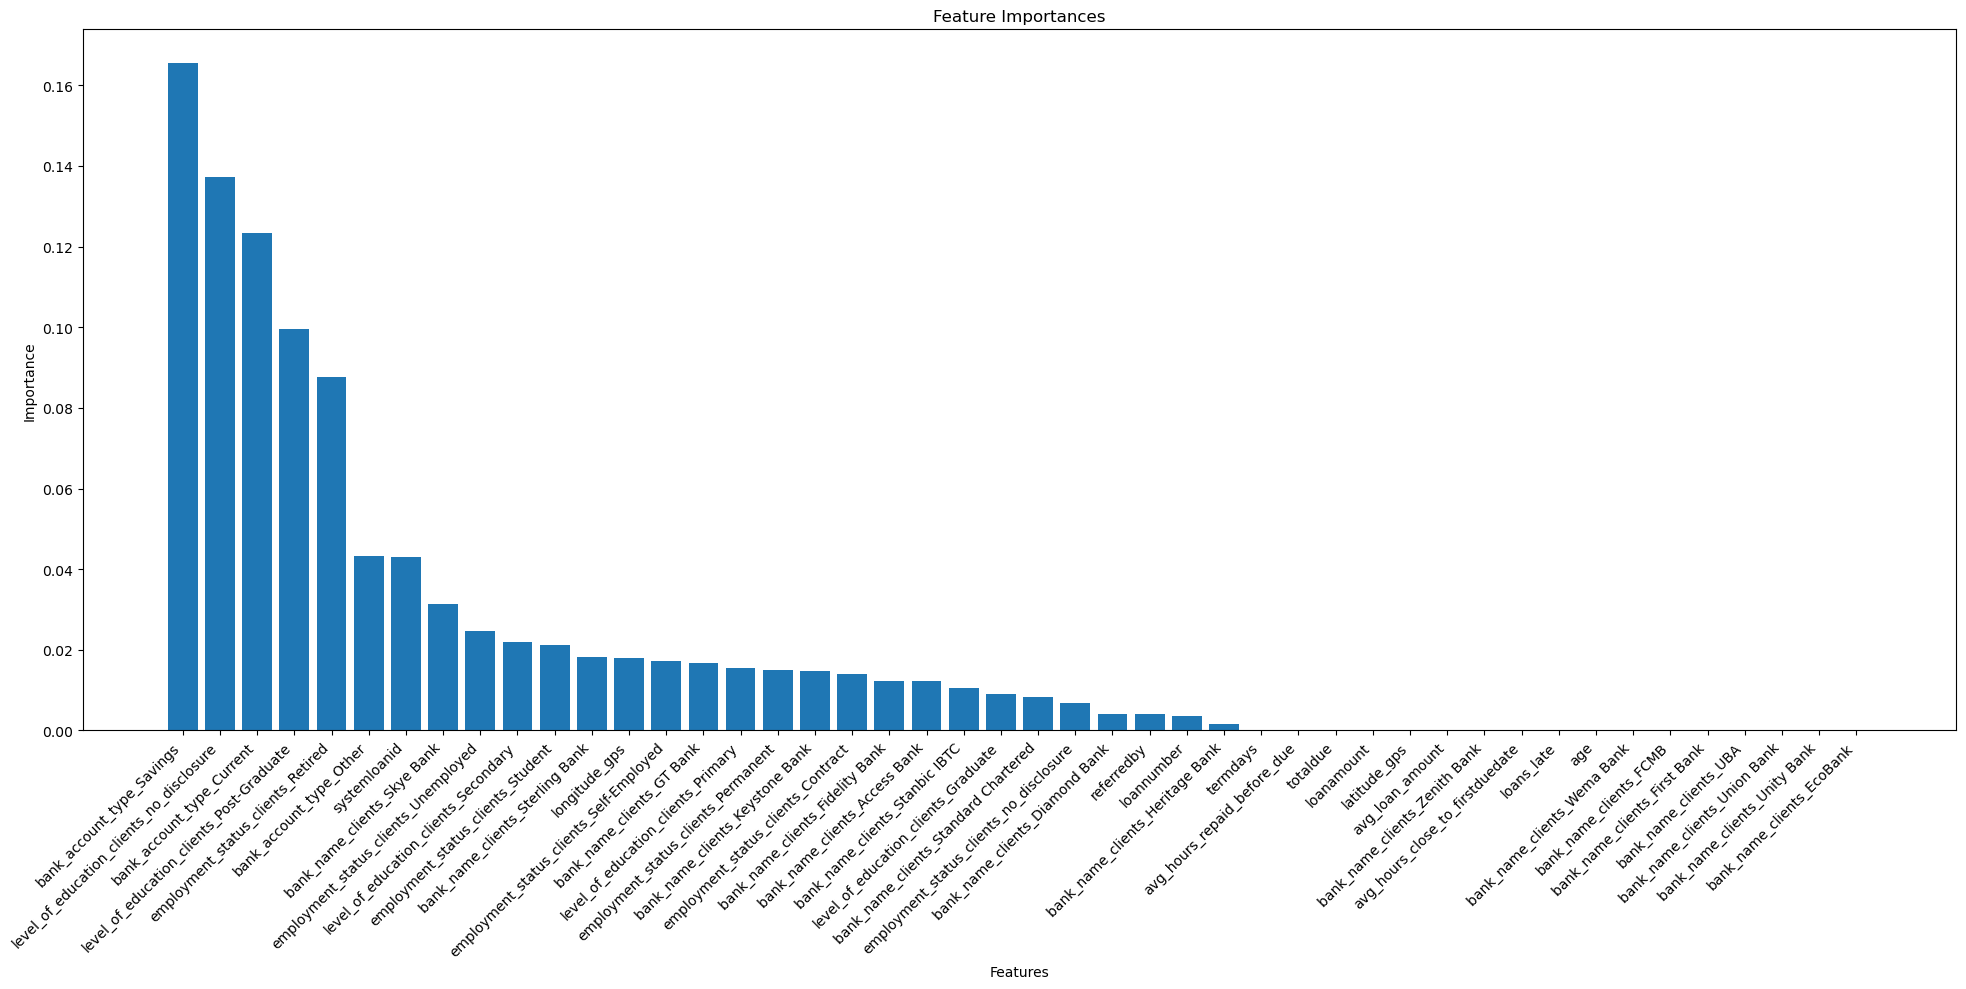

In [45]:
# Get the underlying random forest model from the BalancedRandomForestClassifier
random_forest_model = random_search.best_estimator_[0]

# Get the feature importances from the random forest model
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the ColumnTransformer
feature_names = list(pipeline_full.named_transformers_['numerical'].get_feature_names_out(input_features=columns_numerical)) + \
               list(pipeline_full.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(input_features=columns_categorical))



# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(20,10))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

DROP UNIMPORTANT FEATURES TO SEE IF THE MODEL IMPROVED

In [ ]:
pip install --upgrade scikit-learn


Confusion Matrix for New Random Forest Model:
 [[104  74]
 [158 482]]
Classification Report for New Random Forest Model:
               precision    recall  f1-score   support

           0       0.40      0.58      0.47       178
           1       0.87      0.75      0.81       640

    accuracy                           0.72       818
   macro avg       0.63      0.67      0.64       818
weighted avg       0.76      0.72      0.73       818

Test Accuracy: 0.7163814180929096
AUC Score of the final Model: 0.6974016853932585


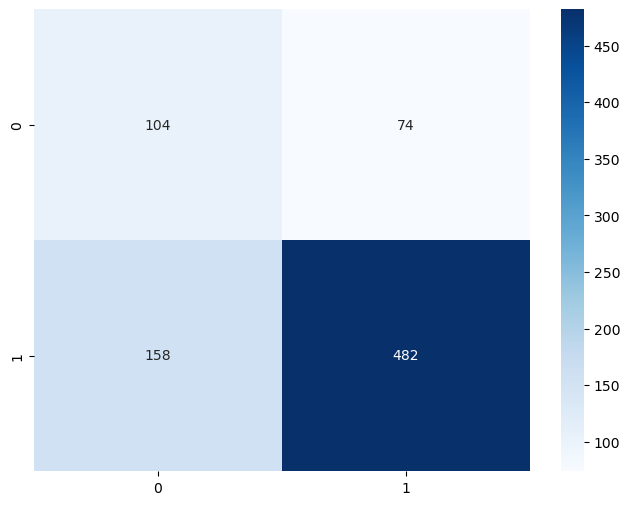

In [61]:
from pandas.core.arrays.datetimelike import final
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Create a mask to filter out features with importance less than 0.001
mask = feature_importances >= 0.002

# Filter the feature names and importances using the mask
filtered_feature_names = np.array(feature_names)[mask]
filtered_feature_importances = feature_importances[mask]


# Create a new DataFrame with the filtered features
X_train_filtered = X_train_transformed[:, mask]
X_test_filtered = X_test_transformed[:, mask]

# Build a new random forest model using the filtered features
final_brf_clf = BalancedRandomForestClassifier(n_estimators=135, max_samples= .1, max_features=9,random_state=42)
final_brf_clf.fit(X_train_filtered, y_train)

# Make predictions on the test data using the new model
y_pred_new = final_brf_clf.predict(X_test_filtered)

# Evaluate the model's performance
print("Confusion Matrix for New Random Forest Model:\n", confusion_matrix(y_test, y_pred_new))
cm = confusion_matrix(y_test, y_pred_new)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
print("Classification Report for New Random Forest Model:\n", classification_report(y_test, y_pred_new))

#  Evaluate the model's performance
y_prob_new = final_brf_clf.predict_proba(X_test_filtered)[:, 1] 
# Calculate accuracy (you can use any other metric you prefer)
accuracy = accuracy_score(y_test, y_pred_new)
print('Test Accuracy:', accuracy)
print("AUC Score of the final Model:", roc_auc_score(y_test, y_prob_new))

In [ ]:
pip install imbalanced-learn


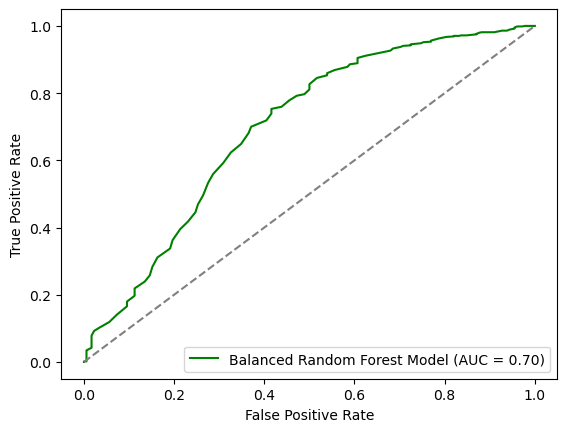

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier
from matplotlib import pyplot as plt

# Calculate the probabilities for class 1 (positive class) for ROC curve

y_prob = final_brf_clf.predict_proba(X_test_filtered)[:,1]

# Calculate the ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calculate the AUC

auc = roc_auc_score(y_test, y_prob)
# Plot the ROC curves for both models on the same chart

plt.plot(fpr, tpr, color='g', label='Balanced Random Forest Model (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [53]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(final_brf_clf, X_test_filtered, y_test)

Text(0.5, 0, 'Permutation Importance')

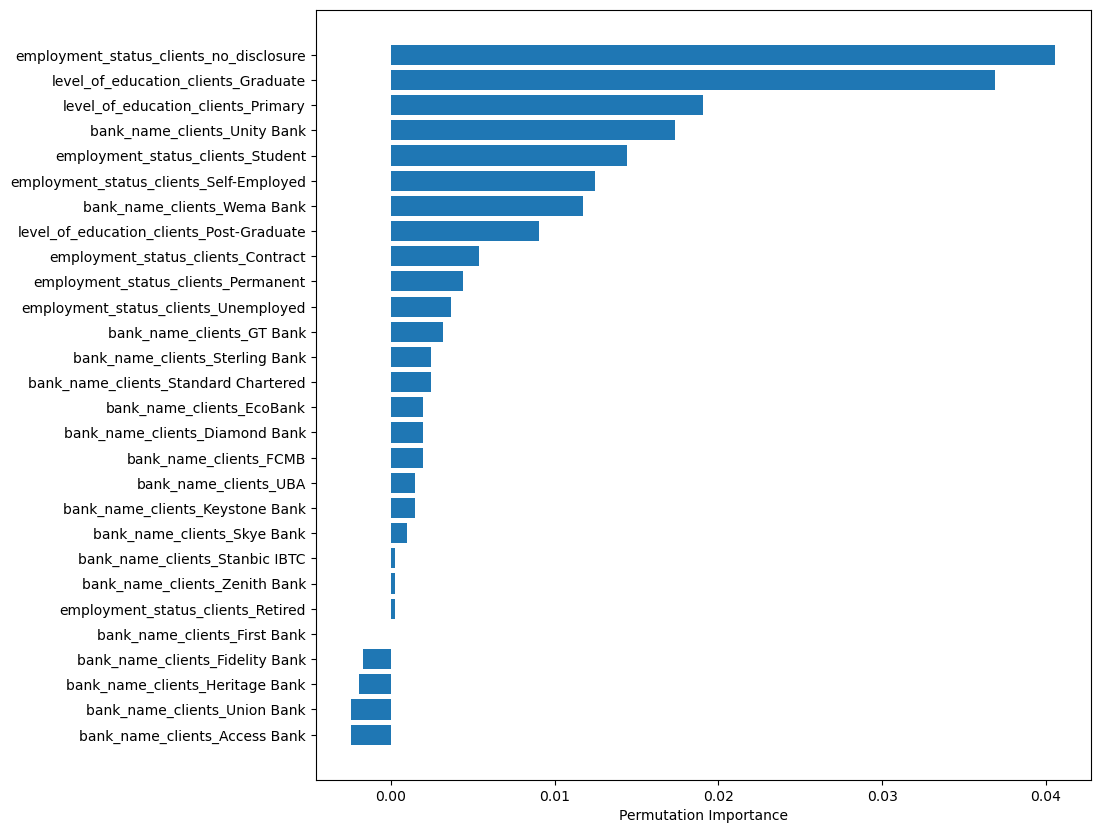

In [54]:
sorted_idx = perm_importance.importances_mean.argsort()
feature_names=pipeline_full.get_feature_names_out()
feature_names=np.array([x.split("__")[1] for x in feature_names])
fig,ax=plt.subplots(figsize=(10,10))
ax.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
ax.set_xlabel("Permutation Importance")


After dropping unimportant features, the Recall of class 0 imporved from 0.57 to 0.58, we will use this as the final model. If we have more time, we may do further hyperparameter tunning to optimize our model